In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import shap
import gpplot as gpp
gpp.set_aesthetics(context='paper')

In [2]:
def load_hyperparams(filename):
    hyperparams = {}
    with open(filename, 'r') as f:
        for line in f:
            key, value = line.strip().split(': ')
            try:
                value = float(value) if '.' in value else int(value)
            except ValueError:
                pass  
            hyperparams[key] = value
    return hyperparams

In [3]:
best_hyperparams = load_hyperparams('../../Data/modelTraining/best_hyperparams_rs3i.txt')
best_hyperparams

{'lambda': 0.17009727814148629,
 'alpha': 7.787656413036318,
 'subsample': 0.478397542562906,
 'colsample_bytree': 0.9245770035679429,
 'max_depth': 4,
 'learning_rate': 0.09085488055743433,
 'n_estimators': 92}

In [4]:
#load and format training data
modelTrainingPath = "../../Data/modelTraining/"
train_df = pd.read_csv(f'{modelTrainingPath}trainData_rs3i.csv')
X = train_df.drop(columns=['doubleZscore', 'Target_Gene_Symbol','sgRNA_Context_Sequence']).copy()
y = train_df['doubleZscore']

# train the final model on the full train dataset
final_model = xgb.XGBRegressor(**best_hyperparams)
final_model.fit(X, y)

# save this model (it uses one hot coding)
final_model.save_model(f'{modelTrainingPath}RS3i.json')

In [5]:
#load and format testing data
test_df = pd.read_csv(f'{modelTrainingPath}testData_rs3i.csv')
Xtest = test_df.drop(columns=['doubleZscore', 'Target_Gene_Symbol','sgRNA_Context_Sequence']).copy()
ytest = test_df['doubleZscore']

#apply model to test dataset
predictions_test = final_model.predict(Xtest)
rmse_test = mean_squared_error(ytest, predictions_test, squared=False)
print(f"RMSE on the testing data: {rmse_test:.4f}")

RMSE on the testing data: 0.8314


In [6]:
test_df['yPred'] = final_model.predict(Xtest)

In [7]:
test_df

,Target_Gene_Symbol,sgRNA_Context_Sequence,sgRNA_'Cut'_Site_TSS_Offset,rs3ChenSeqScore,doubleZscore,ATAC_overlap_with_peak__0.0__0.5_,ATAC_overlap_with_peak__0.5__1.0_,ATAC_overlap_with_peak__1.0__inf_,yPred
0,ATIC,AAAATTAGACGGGTGTGGAGGCAGAGGCAG,-923,0.1365,-0.199624,1,0,0,-0.506243
1,ATIC,TTAGACGGGTGTGGAGGCAGAGGCAGGAGA,-919,-0.4382,-0.419226,1,0,0,-0.502267
2,ATIC,CAAAAAAACAACAAACAAAAAGGGAGGATG,-416,-0.2522,0.156149,1,0,0,-0.506632
3,ATIC,AAAACAACAAACAAAAAGGGAGGATGGTAG,-412,-0.3857,-0.152352,1,0,0,-0.525278
4,ATIC,ATAGCGGCAAAGCTGGAAAGTATCTGGACA,-389,-0.5175,-0.423902,1,0,0,-0.538713
...,...,...,...,...,...,...,...,...,...
23414,ZNHIT6,GGAGTCAGACGGCGTTCGCGGGGGTGGGTT,948,-1.2551,-0.840383,1,0,0,-0.557668
23415,ZNHIT6,GAGTCAGACGGCGTTCGCGGGGGTGGGTTG,949,-0.3818,-0.637729,1,0,0,-0.422886
23416,ZNHIT6,ATACATGAAATTAGTAGTGTCCAATGGGTA,1025,-0.2449,-0.527092,1,0,0,-0.381683
23417,ZNHIT6,TACATGAAATTAGTAGTGTCCAATGGGTAA,1026,0.0806,-0.173052,1,0,0,-0.303991


In [8]:
def calculate_spearman_within_groups(df):
    spearman_corrs = []
    groups = df['Target_Gene_Symbol'].unique()
    
    for group in groups:
        group_data = df[df['Target_Gene_Symbol'] == group]
        yPred_corr, _ = spearmanr(group_data['doubleZscore'], group_data['yPred'])
        RS3_corr, _ = spearmanr(group_data['doubleZscore'], group_data['rs3ChenSeqScore'])
        spearman_corrs.append({'Target_Gene_Symbol': group, 'spearman_corr_crispri_model': yPred_corr, 'spearman_corr_RS3seq': RS3_corr})
    
    return pd.DataFrame(spearman_corrs)

spearman_df = calculate_spearman_within_groups(test_df)

{'whiskers': [<matplotlib.lines.Line2D at 0x3058e9b50>,
 'caps': [<matplotlib.lines.Line2D at 0x3059070d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x3058e98b0>,
 'medians': [<matplotlib.lines.Line2D at 0x305907610>,
 'fliers': [<matplotlib.lines.Line2D at 0x3059078b0>,
 'means': []}

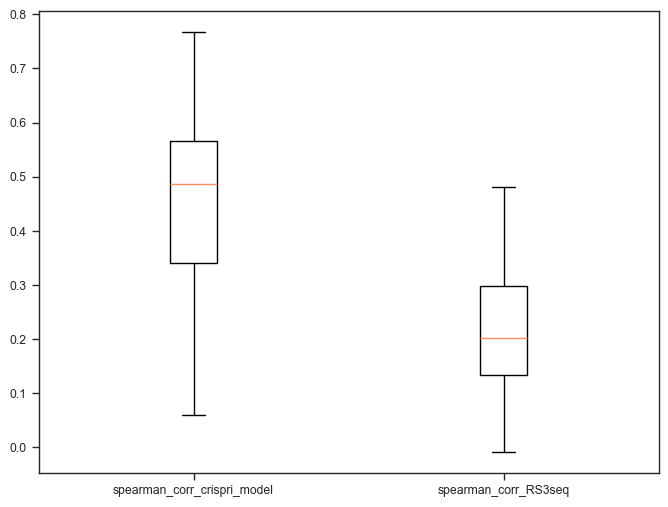

In [9]:
# Plot the boxplot of Spearman correlations
plt.figure(figsize=(8, 6))
plt.boxplot(spearman_df[['spearman_corr_crispri_model', 'spearman_corr_RS3seq']], 
            labels=['spearman_corr_crispri_model', 'spearman_corr_RS3seq'])

In [10]:
explainer = shap.TreeExplainer(final_model)

In [11]:
shap_values = explainer(Xtest)

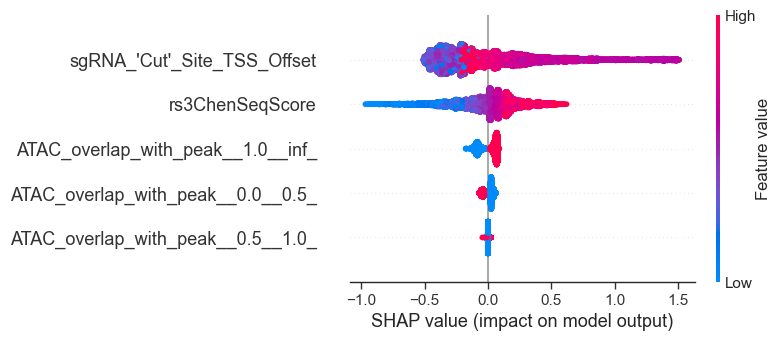

In [12]:
shap.summary_plot(shap_values, Xtest)

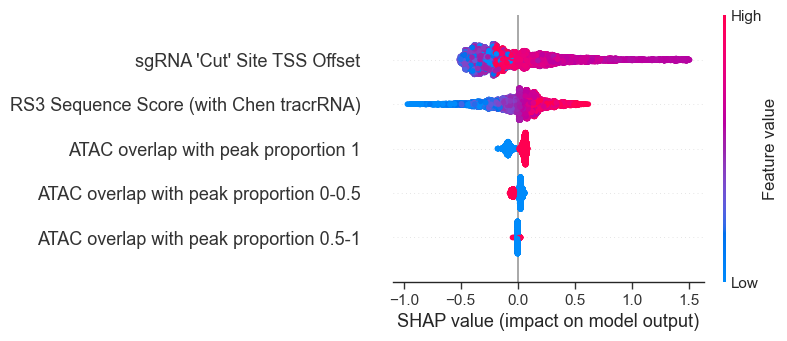

In [13]:
Xtest_renamed = Xtest.copy()
Xtest_renamed.columns = ['Distance to MANE Select TSS', 'RS3 Sequence Score (with Chen tracrRNA)',
                         'In ATAC peak in 0-0.5 of cell lines','ATAC overlap with peak proportion 0.5-1',
                         'ATAC overlap with peak proportion 1']
Xtest_renamed
shap_values = explainer(Xtest_renamed)

shap.summary_plot(shap_values, Xtest, show=False)
gpp.savefig('../../Figures/Figure 4/shap_summary_rs3i.pdf', bbox_inches='tight')

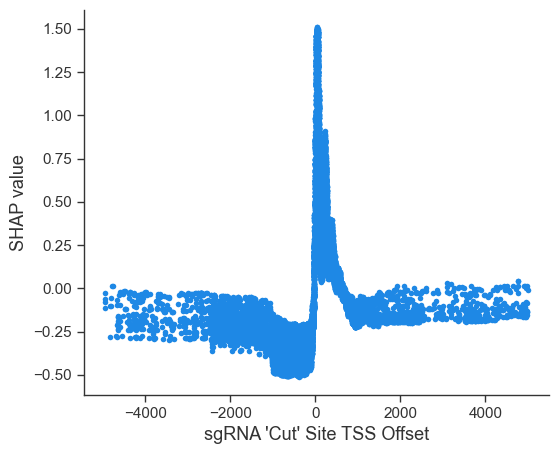

In [48]:
shap.dependence_plot("sgRNA \'Cut\' Site TSS Offset", shap_values.values, Xtest_renamed, interaction_index=None, show=False)
plt.ylabel('SHAP value')
gpp.savefig('../../Figures/Figure 4/shap_tss_offset_dependence.pdf', bbox_inches='tight', dpi=300)

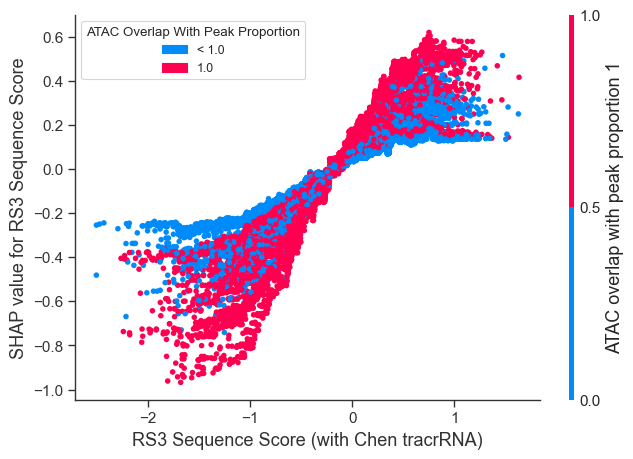

In [50]:
shap.dependence_plot('RS3 Sequence Score (with Chen tracrRNA)', shap_values.values, Xtest_renamed,
                     interaction_index='ATAC overlap with peak proportion 1', show=False)
plt.ylabel('SHAP value for RS3 Sequence Score')

import matplotlib.patches as mpatches
low_patch = mpatches.Patch(color='#008BFB', label='< 1.0')
high_patch = mpatches.Patch(color='#FF0051', label='1.0')

plt.legend(handles=[low_patch, high_patch], title='ATAC Overlap With Peak Proportion')

gpp.savefig('../../Figures/Figure 4/shap_rs3seq_dependence.pdf', bbox_inches='tight', dpi=300)

In [57]:
atac_columns = Xtest_renamed.columns[Xtest_renamed.columns.str.contains('ATAC')]
atac_shap_df = Xtest_renamed[atac_columns].melt(var_name = 'bin',value_name = 'in bin')

atac_shap_df['shap_value'] = pd.DataFrame(shap_values.values[:,2:],columns = atac_columns).melt()['value']
plot_df = atac_shap_df[atac_shap_df['in bin'] == 1]
plot_df.loc[:,'bin'] = plot_df['bin'].map({'ATAC overlap with peak proportion 0-0.5':'[0,0.5)',
                                     'ATAC overlap with peak proportion 0.5-1':'[0.5,1.0)',
                                     'ATAC overlap with peak proportion 1':'1.0'})

/var/folders/mj/lhpd16ys0cx2wkbhm7s0nfcm0000gp/T/ipykernel_41550/3016434256.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.loc[:,'bin'] = plot_df['bin'].map({'ATAC overlap with peak proportion 0-0.5':'[0,0.5)',


In [58]:
plot_df['n'] = plot_df.groupby('bin')['in bin'].transform('count').astype(str)

/var/folders/mj/lhpd16ys0cx2wkbhm7s0nfcm0000gp/T/ipykernel_41550/197098762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['n'] = plot_df.groupby('bin')['in bin'].transform('count').astype(str)


In [59]:
plot_df['bin_label'] = plot_df['bin'] + '\nn = ' + plot_df['n']

/var/folders/mj/lhpd16ys0cx2wkbhm7s0nfcm0000gp/T/ipykernel_41550/2730462746.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['bin_label'] = plot_df['bin'] + '\nn = ' + plot_df['n']


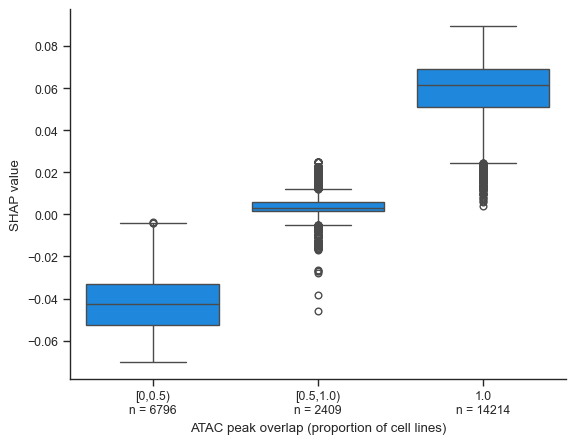

In [60]:
sns.boxplot(data = plot_df, x = 'bin_label', y = 'shap_value', color = '#008BFB')
#plt.xticks(ticks = plot_df['bin'].unique(), labels = Xtest['ATAC_overlap_with_peak'].unique().tolist())
plt.xlabel('ATAC peak overlap (proportion of cell lines)')
plt.ylabel('SHAP value')
sns.despine()


gpp.savefig('../../Figures/Figure 4/shap_atac_peak_overlap_dependence.pdf', bbox_inches='tight', dpi=300)